In [1]:
!pip install gensim
!pip install underthesea
!pip install pandas_profiling

In [2]:
!pip install demoji
!pip install pyvi

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
import re
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer

<ipython-input-3-12519522ee05>:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

%cd '/content/gdrive/My Drive/MDS0/LDS0_K287_Online_MaQuocDung/data/'

Mounted at /content/gdrive
/content/gdrive/My Drive/MDS0/LDS0_K287_Online_MaQuocDung/data


In [5]:
import sklearn

In [6]:
print(sklearn.__version__)

1.2.2


In [7]:
# https://underthesea.readthedocs.io/en/v1.1.5/readme.html
# https://github.com/undertheseanlp/underthesea

In [8]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [9]:
def process_text(text, emoji_dict, teen_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        # ...
        ###### DEL wrong words
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '
    document = new_sentence
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    #...
    return document

In [10]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [11]:
def process_special_word(text):
    # có thể có nhiều từ đặc biệt cần ráp lại với nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # không, chẳng, chả...
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [12]:
def translate_text(text):
    words = text.split()
    translated_words = [english_dict.get(word.lower(), word) for word in words]
    return ' '.join(translated_words)

In [13]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        # lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [14]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

## Tạo thêm các cột mới dựa trên việc đếm từ/icon positive và negative
- Tạo danh sách các từ positive -> lưu vào file positive_VN.txt (mỗi từ trên 1 dòng)
- Tạo danh sách các từ negative -> lưu vào file negative_VN.txt (mỗi từ trên 1 dòng)
- Tạo danh sách các positve emojis -> lưu vào file positive_emoji.txt (mỗi icon trên 1 dòng)
- Tạo danh sách các negative emojis -> lưu vào file negative_emoji.txt (mỗi icon trên 1 dòng)
- Đọc vào các list tương ứng
- Viết function để đọc 1 chuỗi -> đếm số lượng positive words/ emojis hoặc  negative words/ ememojis, danh sách từ kết quả
- Tạo ra 2 cột mới cho dataframe: negative_count/ positive_count
- ...

In [15]:
positive_words = [
    "thích", "tốt", "xuất sắc","đúng", "tuyệt vời", "tuyệt hảo", "đẹp", "ổn"
    "hài lòng", "ưng ý", "hoàn hảo", "chất lượng", "thú vị", "nhanh"
    "tiện lợi", "dễ sử dụng", "hiệu quả", "ấn tượng",
    "nổi bật", "tận hưởng", "tốn ít thời gian", "thân thiện", "hấp dẫn",
    "gợi cảm", "tươi mới", "lạ mắt", "cao cấp", "độc đáo",
    "hợp khẩu vị", "rất tốt", "rất thích", "tận tâm", "đáng tin cậy", "đẳng cấp",
    "hấp dẫn", "an tâm", "không thể cưỡng_lại", "thỏa mãn", "thúc đẩy",
    "cảm động", "phục vụ tốt", "làm hài lòng", "gây ấn tượng", "nổi trội",
    "sáng tạo", "quý báu", "phù hợp", "tận tâm",
    "hiếm có", "cải thiện", "hoà nhã", "chăm chỉ", "cẩn thận",
    "vui vẻ", "sáng sủa", "hào hứng", "đam mê", "vừa vặn", "đáng tiền"
]

In [16]:
len(positive_words)

57

In [17]:
negative_words = [
    "kém", "tệ", "đau", "xấu", "bị","rè", "ồn",
    "buồn", "rối", "thô", "lâu", "sai", "hư",
    "tối", "chán", "ít", "mờ", "mỏng", "vỡ", "hư hỏng",
    "lỏng lẻo", "khó", "cùi", "yếu", "mà", "không thích", "không thú vị", "không ổn",
    "không hợp", "không đáng tin cậy", "không chuyên nghiệp", "nhầm lẫn"
    "không phản hồi", "không an toàn", "không phù hợp", "không thân thiện", "không linh hoạt", "không đáng giá",
    "không ấn tượng", "không tốt", "chậm", "khó khăn", "phức tạp", "bị mở", "bị khui","không đúng", "không đúng sản phẩm",
    "khó hiểu", "khó chịu", "gây khó dễ", "rườm rà", "khó truy cập", "bị bóc", "sai sản phẩm",
    "thất bại", "tồi tệ", "khó xử", "không thể chấp nhận", "tồi tệ","không rõ ràng", "giảm chất lượng",
    "không chắc chắn", "rối rắm", "không tiện lợi", "không đáng tiền", "chưa đẹp", "không đẹp"
]

In [18]:
len(negative_words)

66

In [19]:
neutral_words = ["chấp nhận được", "trung bình", "bình thường", "tạm ổn", "trung lập", "có thể"
                 "không nổi bật", "đủ ổn", "đủ tốt", "có thể chấp nhận", "bình thường",
                 "thường xuyên", "tương đối", "hợp lý", "tương tự",
                 "có thể sử dụng", "bình yên", "bình tĩnh", "không quá tệ", "trung hạng",
                 "có thể điểm cộng", "dễ chấp nhận", "không phải là vấn đề",
                 "không phản đối", "không quá đáng kể", "không gây bất ngờ", "không tạo ấn tượng", "có thể chấp nhận",
                 "không gây sốc", "tương đối tốt", "không thay đổi", "không quá phức tạp", "không đáng kể",
                 "chấp nhận", "có thể dễ dàng thích nghi", "không quá cầu kỳ", "không cần thiết", "không yêu cầu nhiều", "không gây hại",
                 "không có sự thay đổi đáng kể", "không rõ ràng", "không quá phê bình", "không đáng chú ý", "không đặc biệt",
                 "không quá phức tạp", "không gây phiền hà", "không đáng kể", "không gây kích thích"]

In [20]:
len(neutral_words)

47

In [21]:
# Danh sách các từ mang ý nghĩa phủ định
negation_words = ["không", "nhưng", "tuy nhiên","sai", "mặc dù", "chẳng", "mà", 'kém', 'giảm']

In [22]:
def find_words(document, list_of_words):
    document_lower = document.lower()
    word_count = 0
    word_list = []

    for word in list_of_words:
        if word in document_lower:
            word_count += document_lower.count(word)
            word_list.append(word)

    return word_count, word_list

In [23]:
# Count emojis positive and negative
negative_emojis = [
    "😞", "😔", "🙁", "☹️", "😕",
    "😢", "😭", "😖", "😣", "😩",
    "😠", "😡", "🤬", "😤", "😰",
    "😨", "😱", "😪", "😓", "🥺",
    "😒", "🙄", "😑", "😬", "😶",
    "🤯", "😳", "🤢", "🤮", "🤕",
    "🥴", "🤔", "😷", "🙅‍♂️", "🙅‍♀️",
    "🙆‍♂️", "🙆‍♀️", "🙇‍♂️", "🙇‍♀️", "🤦‍♂️",
    "🤦‍♀️", "🤷‍♂️", "🤷‍♀️", "🤢", "🤧",
    "🤨", "🤫", "👎", "👊", "✊", "🤛", "🤜",
    "🤚", "🖕"
]

In [24]:
len(negative_emojis)

54

In [25]:
positive_emojis = [
    "😄", "😃", "😀", "😁", "😆",
    "😅", "🤣", "😂", "🙂", "🙃",
    "😉", "😊", "😇", "🥰", "😍",
    "🤩", "😘", "😗", "😚", "😙",
    "😋", "😛", "😜", "🤪", "😝",
    "🤗", "🤭", "🥳", "😌", "😎",
    "🤓", "🧐", "👍", "🤝", "🙌", "👏", "👋",
    "🤙", "✋", "🖐️", "👌", "🤞",
    "✌️", "🤟", "👈", "👉", "👆",
    "👇", "☝️"
]

In [26]:
len(positive_emojis)

49

## Bước 1: Business Understanding

Dựa vào yêu cầu nói trên => xác định vấn đề:

Chưa có hệ thống Recommendation System


=> Mục tiêu/ vấn đề: Xây dựng Recommendation System cho một hoặc một số nhóm hàng hóa trên tiki.vn giúp đề xuất và gợi ý cho người dùng/ khách hàng. => Xây dựng các mô hình đề xuất:


*   Content-based filtering
*   Collaborative filtering

## Bước 2: Data Understanding

In [27]:
data = pd.read_csv('Sendo_reviews.csv')

In [28]:
data_tiki = pd.read_csv('Tiki_reviews.csv')

In [29]:
data.head(1)

,product_id,customer_id,full_name,created_time,rating,content
0,10119100,trang,trang,09:27 | 08/05/2021,5,NaN


In [30]:
data_tiki.head(5)

,id,title,content,thank_count,customer_id,rating,customer_name
0,NaN,Cực kì hài lòng,"Sản phẩm được giao nhanh chóng, kỹ lưỡng. Cây ...",0,23378479,5,Quang Huy
1,NaN,Rất không hài lòng,Cây lau nhà lỗi ko thể dùng được. Lắp vào ko q...,0,7403888,1,Đanh Đá
2,NaN,Rất không hài lòng,"Hàng méo cong vênh, chốt xoay gãy, mỏng yếu, y...",0,15199,1,Nguyen Hai Yen
3,NaN,Cực kì hài lòng,tốt,0,21549258,5,Huy Bùi
4,NaN,Cực kì hài lòng,tốt dễ dàng sử dụng,0,19075408,5,Nguyên Huu Tuyen


### Thực hiện EDA

In [31]:
ProfileReport(data, title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
ProfileReport(data_tiki, title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
# Distribution of ratings
print("\nDistribution of ratings:")
rating_distribution = data['rating'].value_counts().sort_index()
print(rating_distribution)


Distribution of ratings:
1     274
2     141
3     263
4     604
5    5942
Name: rating, dtype: int64


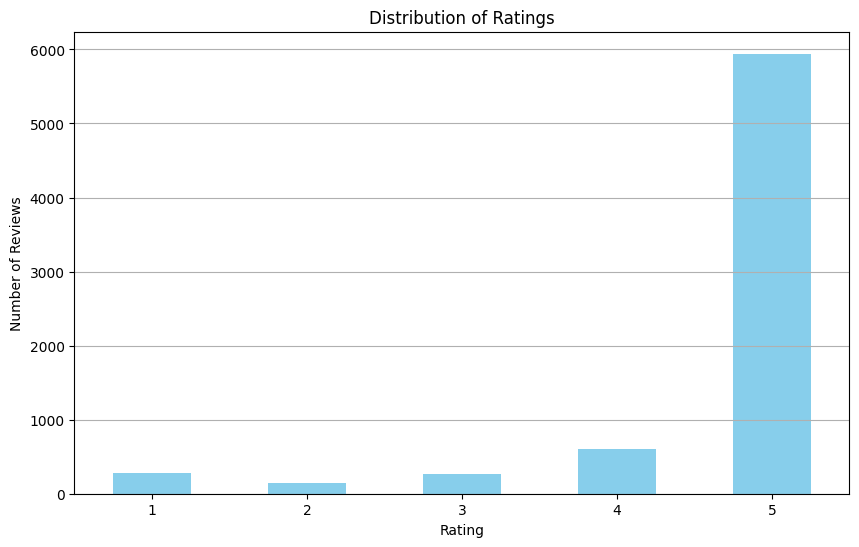

In [34]:
# Plotting the distribution of ratings
plt.figure(figsize=(10, 6))
rating_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Số lượt đánh giá 5* khá cao, đồ thị có xu hướng lệch trái, dữ liệu bị mất cân đối

In [35]:
# Number of reviews per product
reviews_per_product = data['product_id'].value_counts()
print("\nTop 10 products with most reviews:")
print(reviews_per_product.head(30))


Top 10 products with most reviews:
28493686     10
18556680     10
114359176    10
17487537     10
17256765     10
23081167     10
115049631    10
13529430     10
23129357     10
23208993     10
10536769     10
23237384     10
9834363      10
16694631     10
8816826      10
8815584      10
8815416      10
8815164      10
8814885      10
7927658      10
48281936     10
48226795     10
48226680     10
46751301     10
40208692     10
37878086     10
37576543     10
37145147     10
11789447     10
114359173    10
Name: product_id, dtype: int64


Số lượng sản phẩm được review nhiều nhất khoản 10 chỉ khoản 10 review

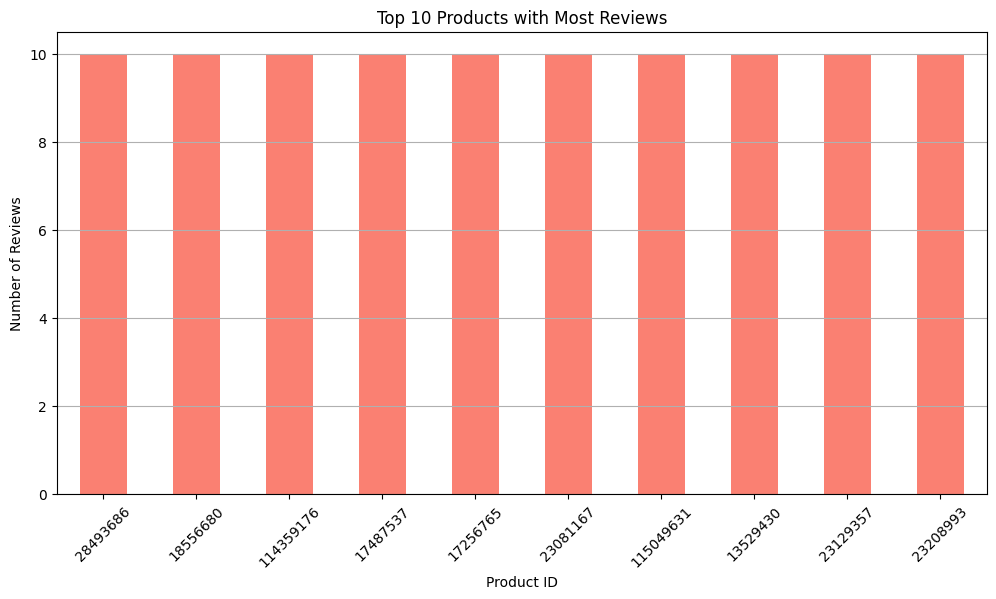

In [36]:
# Plotting the top 10 products with the most reviews
plt.figure(figsize=(12, 6))
reviews_per_product.head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 Products with Most Reviews')
plt.xlabel('Product ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [37]:
reviews_per_product.describe()

count    1439.000000
mean        5.020153
std         3.660527
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max        10.000000
Name: product_id, dtype: float64

Không có sự chênh lệch quá lớn trong số lượng review các sản phẩm

In [38]:
# Calculate the number of reviews per customer
reviews_per_customer = data['customer_id'].value_counts()

# Use the describe() function on the number of reviews per customer
reviews_per_customer.describe()

count    5514.000000
mean        1.310120
std         1.850561
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       113.000000
Name: customer_id, dtype: float64

In [39]:
print(reviews_per_customer.head(30))

Danhgiaandanh                         113
0***                                   47
NGOTHITHUHIEN                          17
noithatxinh10                          15
NguyenPhuong                           14
09789008160978900816                   13
trancongminhduc2012                    12
trang                                  12
tranhtheutranhdinhda1988@gmail.com     10
NguyenThuyKhue                          9
Thao                                    9
ngocha                                  8
NguyenThao                              8
ThaoNguyen                              8
HanhNguyen                              8
MaiAnh2016                              8
NguyenThuy                              8
Trang                                   8
NguyenHang                              7
thuythuy                                7
NgocMai                                 7
NguyenThu                               7
NguyenPhuongAnh                         7
HienNguyen                        

Có sự chênh lệch khá lớn giữa mức mean = 1,3 và khách hàng có lượt review nhiều nhất là 113, tứ phân vị cũng cho thấy trên 75% khách hàng chỉ có 1 lượt review

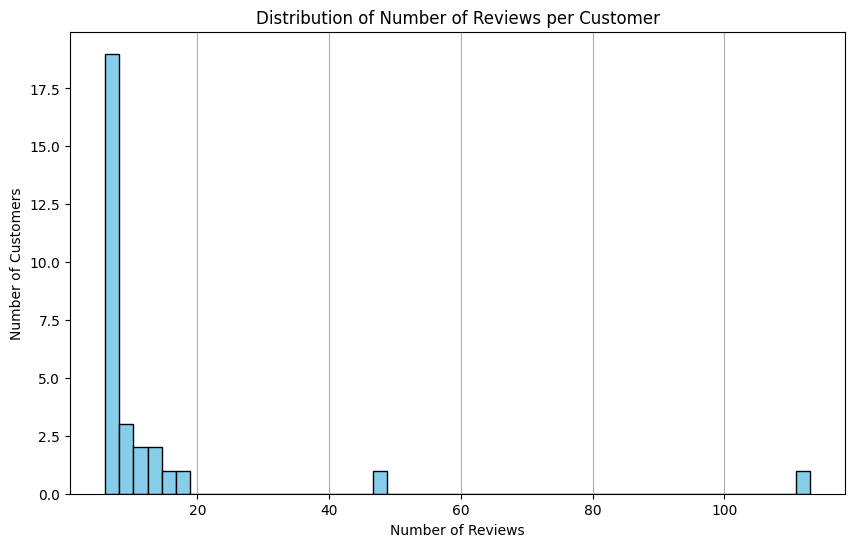

In [40]:
# Plotting the distribution of reviews per customer
plt.figure(figsize=(10, 6))
reviews_per_customer.head(30).hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Reviews per Customer')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.show()

In [41]:
data

,product_id,customer_id,full_name,created_time,rating,content
0,10119100,trang,trang,09:27 | 08/05/2021,5,NaN
1,10119100,NguyenCatTuong,Nguyễn Cát Tường,20:22 | 21/12/2018,4,Shop phục vụ khá tốt.
2,10119100,VuPhuong,Vũ Phương,15:00 | 10/12/2018,3,Sản phẩm gần giống mô tả
3,10119490,hoangthisuong,hoàng thị sương,22:43 | 06/03/2022,5,NaN
4,10119490,DAITRANG,ĐÀI TRANG,12:22 | 02/12/2021,5,NaN
...,...,...,...,...,...,...
7219,25113665,thuythanh,thuy thanh,21:03 | 23/02/2020,4,NaN
7220,25113665,thuythanh,thuy thanh,21:03 | 23/02/2020,4,NaN
7221,25113665,thuythanh,thuy thanh,21:03 | 23/02/2020,4,NaN
7222,25113665,tranthingoclien,tranthingoclien,04:53 | 23/02/2020,4,NaN


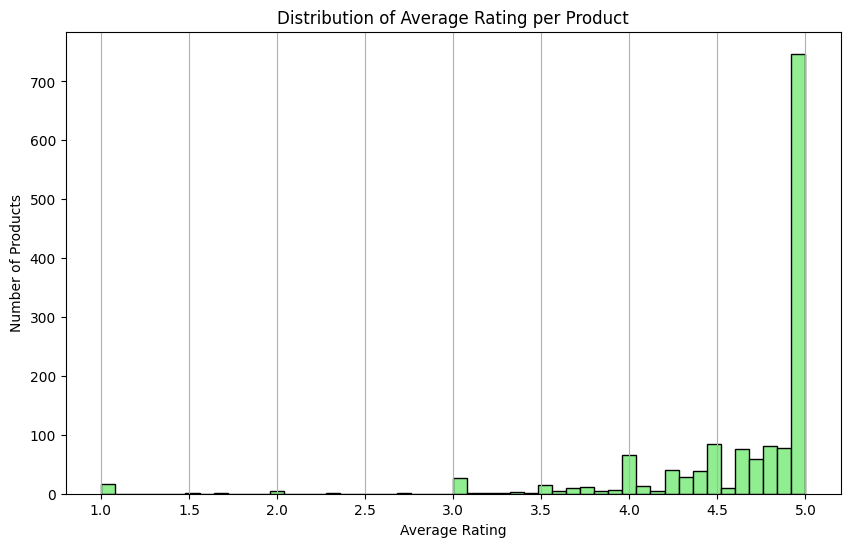

In [42]:
# Average rating per product
average_rating = data.groupby('product_id')['rating'].mean()

plt.figure(figsize=(10, 6))
average_rating.hist(bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Average Rating per Product')
plt.xlabel('Average Rating')
plt.ylabel('Number of Products')
plt.grid(axis='y')
plt.show()

Điểm đánh giá trung bình của các sản phẩm của khá cao, ở mức 5 chiếm đa số

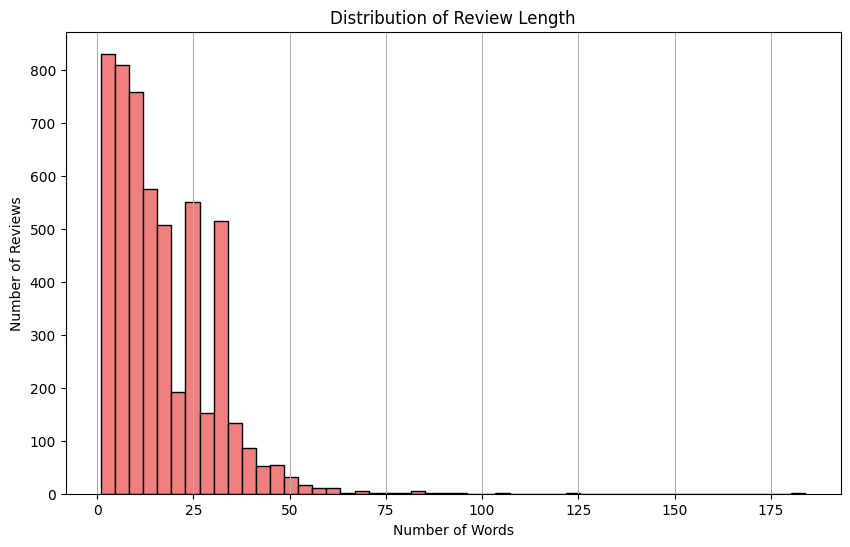

In [43]:
# Number of words in each review
data['review_length'] = data['content'].dropna().apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
data['review_length'].hist(bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Review Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(axis='y')
plt.show()

Các comment đa phần có nội dung ngắn, dưới 50 chữ

## Bước 3: Data Preparation/Prepare

In [44]:
# Loại bỏ các hàng trùng lặp tệp Sendo
data = data.drop_duplicates()

#Loại bỏ các hàng trùng lặp tệp Tiki
#data_tiki = data_tiki.drop_duplicates()

In [45]:
# Danh sách các cột bạn muốn giữ lại
columns_to_keep = ['content', 'rating']

# Tạo một DataFrame mới chỉ chứa các cột bạn muốn giữ lại
data = data[columns_to_keep]
data_tiki = data_tiki[columns_to_keep]

In [46]:
data_tiki

,content,rating
0,"Sản phẩm được giao nhanh chóng, kỹ lưỡng. Cây ...",5
1,Cây lau nhà lỗi ko thể dùng được. Lắp vào ko q...,1
2,"Hàng méo cong vênh, chốt xoay gãy, mỏng yếu, y...",1
3,tốt,5
4,tốt dễ dàng sử dụng,5
...,...,...
9571,"Hang đong goi ok , sản phẩm chưa sủ dụng , cho...",4
9572,"Giao hàng nhanh hơn dự kiến, đúng mẫu. Pin ok ...",5
9573,Tikinow giao quá nhanh 😊😊😊,5
9574,"Giao hàng nhanh, pin chính hãng nguyên đai ngu...",5


In [47]:
data = data.append(data_tiki, ignore_index=True)

<ipython-input-47-865a7d5641fc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data_tiki, ignore_index=True)


In [48]:
data

,content,rating
0,NaN,5
1,Shop phục vụ khá tốt.,4
2,Sản phẩm gần giống mô tả,3
3,NaN,5
4,NaN,5
...,...,...
16695,"Hang đong goi ok , sản phẩm chưa sủ dụng , cho...",4
16696,"Giao hàng nhanh hơn dự kiến, đúng mẫu. Pin ok ...",5
16697,Tikinow giao quá nhanh 😊😊😊,5
16698,"Giao hàng nhanh, pin chính hãng nguyên đai ngu...",5


In [49]:
data = data.copy()
data['sentiment'] = data['rating'].apply(lambda x: 'positive' if x > 3 else ('neutral' if x == 3 else 'negative'))

In [50]:
# Data preparation
data = data.dropna(subset=['content']).copy()  # Create a copy to avoid warnings

In [51]:
data = data.dropna(subset=['rating']).copy()  # Create a copy to avoid warnings

In [52]:
data

,content,rating,sentiment
1,Shop phục vụ khá tốt.,4,positive
2,Sản phẩm gần giống mô tả,3,neutral
5,Giao hàng nhanh bất ngờ.,5,positive
6,Sản phẩm/dịch vụ giống mô tả.,4,positive
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,5,positive
...,...,...,...
16695,"Hang đong goi ok , sản phẩm chưa sủ dụng , cho...",4,positive
16696,"Giao hàng nhanh hơn dự kiến, đúng mẫu. Pin ok ...",5,positive
16697,Tikinow giao quá nhanh 😊😊😊,5,positive
16698,"Giao hàng nhanh, pin chính hãng nguyên đai ngu...",5,positive


In [53]:
# Áp dụng hàm xử lý vào cột "content"
data['new_content'] = data['content'].apply(lambda x: process_text(x, emoji_dict, teen_dict, wrong_lst))

In [54]:
data[['content','new_content']].head(20)

,content,new_content
1,Shop phục vụ khá tốt.,shop phục vụ khá tốt.
2,Sản phẩm gần giống mô tả,sản phẩm gần giống mô tả.
5,Giao hàng nhanh bất ngờ.,giao hàng nhanh bất ngờ.
6,Sản phẩm/dịch vụ giống mô tả.,sản phẩm dịch vụ giống mô tả.
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,sản phẩm dịch vụ giống mô tả và tốt hơn mong đ...
8,"Shop tư vấn, hướng dẫn cực kỳ nhiệt tình.",shop tư vấn hướng dẫn cực kỳ nhiệt tình.
10,Sản phẩm tốt vượt mong đợi,sản phẩm tốt vượt mong đợi.
11,Sản phẩm đúng mô tả,sản phẩm đúng mô tả.
12,Hài lòng,hài lòng.
13,sản phẩm giao hàng nhanh chóng. đóng gói chưa ...,sản phẩm giao hàng nhanh chóng. đóng gói chưa ...


In [55]:
data['new_content'] = data['new_content'].apply(lambda x: covert_unicode(x))

In [56]:
data['new_content'] = data['new_content'].apply(lambda x: translate_text(x))

In [57]:
data[['content','new_content']].head(20)

,content,new_content
1,Shop phục vụ khá tốt.,cửa tiệm phục vụ khá tốt.
2,Sản phẩm gần giống mô tả,sản phẩm gần giống mô tả.
5,Giao hàng nhanh bất ngờ.,giao hàng nhanh chóng bất ngờ.
6,Sản phẩm/dịch vụ giống mô tả.,sản phẩm dịch vụ giống mô tả.
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,sản phẩm dịch vụ giống mô tả và tốt hơn mong đ...
8,"Shop tư vấn, hướng dẫn cực kỳ nhiệt tình.",cửa tiệm tư vấn hướng dẫn cực kỳ nhiệt tình.
10,Sản phẩm tốt vượt mong đợi,sản phẩm tốt vượt mong đợi.
11,Sản phẩm đúng mô tả,sản phẩm đúng mô tả.
12,Hài lòng,hài lòng.
13,sản phẩm giao hàng nhanh chóng. đóng gói chưa ...,sản phẩm giao hàng nhanh chóng chóng. đóng gói...


In [58]:
#data['new_content'] = data['new_content'].apply(lambda x: process_postag_thesea(x))

In [59]:
#data[['content','new_content']].head(30)

In [60]:
# Thêm cột "neutral_words_count" vào DataFrame data
data['neutral_words_count'] = data['new_content'].apply(lambda x: find_words(x, neutral_words)[0])

In [61]:
# Thêm cột "negative_words_count" vào DataFrame data
data['negative_words_count'] = data['new_content'].apply(lambda x: find_words(x, negative_words)[0])

In [62]:
# Thêm cột "positive_words_count" và "positive_words_list" vào DataFrame data
data['positive_words_count'] = data['new_content'].apply(lambda x: find_words(x, positive_words)[0])

# Thêm cột "negative_words_count" vào DataFrame data
data['negation_words_count'] = data['new_content'].apply(lambda x: find_words(x, negation_words)[0])

# Trừ đi số lượng từ tích cực sau khi trừ đi số lượng từ mang ý nghĩa phủ định
data['positive_words_count'] = data.apply(lambda row: max(row['positive_words_count'] - row['negative_words_count'], 0), axis=1)

In [63]:
# Thêm cột "positive_emoji_count" vào DataFrame data
data['positive_emoji_count'] = data['new_content'].apply(lambda x: find_words(x, positive_emojis)[0])

In [64]:
# Thêm cột "negative_emoji_count" vào DataFrame data
data['negative_emoji_count'] = data['new_content'].apply(lambda x: find_words(x, negative_emojis)[0])

In [65]:
data.head(20)

,content,rating,sentiment,new_content,neutral_words_count,negative_words_count,positive_words_count,negation_words_count,positive_emoji_count,negative_emoji_count
1,Shop phục vụ khá tốt.,4,positive,cửa tiệm phục vụ khá tốt.,0,0,1,0,0,0
2,Sản phẩm gần giống mô tả,3,neutral,sản phẩm gần giống mô tả.,0,0,0,0,0,0
5,Giao hàng nhanh bất ngờ.,5,positive,giao hàng nhanh chóng bất ngờ.,0,0,0,0,0,0
6,Sản phẩm/dịch vụ giống mô tả.,4,positive,sản phẩm dịch vụ giống mô tả.,0,0,0,0,0,0
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,5,positive,sản phẩm dịch vụ giống mô tả và tốt hơn mong đ...,0,1,3,0,0,0
8,"Shop tư vấn, hướng dẫn cực kỳ nhiệt tình.",5,positive,cửa tiệm tư vấn hướng dẫn cực kỳ nhiệt tình.,0,1,0,0,0,0
10,Sản phẩm tốt vượt mong đợi,5,positive,sản phẩm tốt vượt mong đợi.,0,0,1,0,0,0
11,Sản phẩm đúng mô tả,4,positive,sản phẩm đúng mô tả.,0,0,1,0,0,0
12,Hài lòng,5,positive,hài lòng.,0,0,0,0,0,0
13,sản phẩm giao hàng nhanh chóng. đóng gói chưa ...,5,positive,sản phẩm giao hàng nhanh chóng chóng. đóng gói...,0,1,0,0,0,0


In [66]:
# word_tokenize
data['new_content']=data['new_content'].apply(lambda x: word_tokenize(x, format="text"))

In [67]:
data.head(20)

,content,rating,sentiment,new_content,neutral_words_count,negative_words_count,positive_words_count,negation_words_count,positive_emoji_count,negative_emoji_count
1,Shop phục vụ khá tốt.,4,positive,cửa tiệm phục_vụ khá tốt .,0,0,1,0,0,0
2,Sản phẩm gần giống mô tả,3,neutral,sản_phẩm gần giống mô_tả .,0,0,0,0,0,0
5,Giao hàng nhanh bất ngờ.,5,positive,giao hàng nhanh_chóng bất_ngờ .,0,0,0,0,0,0
6,Sản phẩm/dịch vụ giống mô tả.,4,positive,sản_phẩm dịch_vụ giống mô_tả .,0,0,0,0,0,0
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,5,positive,sản_phẩm dịch_vụ giống mô_tả và tốt hơn mong_đ...,0,1,3,0,0,0
8,"Shop tư vấn, hướng dẫn cực kỳ nhiệt tình.",5,positive,cửa tiệm tư_vấn hướng_dẫn cực_kỳ nhiệt_tình .,0,1,0,0,0,0
10,Sản phẩm tốt vượt mong đợi,5,positive,sản_phẩm tốt vượt mong_đợi .,0,0,1,0,0,0
11,Sản phẩm đúng mô tả,4,positive,sản_phẩm đúng mô_tả .,0,0,1,0,0,0
12,Hài lòng,5,positive,hài_lòng .,0,0,0,0,0,0
13,sản phẩm giao hàng nhanh chóng. đóng gói chưa ...,5,positive,sản_phẩm giao hàng nhanh_chóng_chóng . đóng_gó...,0,1,0,0,0,0


In [68]:
data['new_content'] = data['new_content'].apply(lambda x: remove_stopword(x, stopwords_lst))

In [69]:
data.head(50)

,content,rating,sentiment,new_content,neutral_words_count,negative_words_count,positive_words_count,negation_words_count,positive_emoji_count,negative_emoji_count
1,Shop phục vụ khá tốt.,4,positive,phục_vụ tốt .,0,0,1,0,0,0
2,Sản phẩm gần giống mô tả,3,neutral,gần giống .,0,0,0,0,0,0
5,Giao hàng nhanh bất ngờ.,5,positive,nhanh_chóng .,0,0,0,0,0,0
6,Sản phẩm/dịch vụ giống mô tả.,4,positive,giống .,0,0,0,0,0,0
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,5,positive,giống tốt hơn . chất_lượng tốt . . tư_vấn hướn...,0,1,3,0,0,0
8,"Shop tư vấn, hướng dẫn cực kỳ nhiệt tình.",5,positive,tư_vấn hướng_dẫn cực_kỳ nhiệt_tình .,0,1,0,0,0,0
10,Sản phẩm tốt vượt mong đợi,5,positive,tốt vượt .,0,0,1,0,0,0
11,Sản phẩm đúng mô tả,4,positive,.,0,0,1,0,0,0
12,Hài lòng,5,positive,hài_lòng .,0,0,0,0,0,0
13,sản phẩm giao hàng nhanh chóng. đóng gói chưa ...,5,positive,nhanh_chóng_chóng . đóng_gói kĩ . giá_cả tốt ....,0,1,0,0,0,0


In [70]:
from pyvi import ViTokenizer

# Áp dụng POS tagging trực tiếp lên cột new_content của DataFrame
data['new_content'] = data['new_content'].apply(lambda x: ViTokenizer.tokenize(x))

# Hiển thị một số dòng đầu của cột pos_tags
print(data['new_content'].head(20))

1                                         phục_vụ tốt .
2                                           gần giống .
5                                         nhanh_chóng .
6                                               giống .
7     giống tốt hơn . chất_lượng tốt . . tư_vấn hướn...
8                  tư_vấn hướng_dẫn cực_kỳ nhiệt_tình .
10                                           tốt vượt .
11                                                    .
12                                           hài_lòng .
13    nhanh_chóng_chóng . đóng_gói kĩ . giá_cả tốt ....
14    chuyên_nghiệp thân_thiện . đóng_gói kỹ_lưỡng ....
16                                      giống tốt hơn .
18                                           tốt vượt .
19                                           tốt vượt .
20                                                    .
21                                           tốt vượt .
22                               chất_lượng tuyệt_vời .
24                                           tốt

In [71]:
data['new_content'] = data['new_content'].apply(lambda x: re.sub(r'\.', '', x))
data['new_content'].head(20)

1                                          phục_vụ tốt 
2                                            gần giống 
5                                          nhanh_chóng 
6                                                giống 
7     giống tốt hơn  chất_lượng tốt   tư_vấn hướng_d...
8                   tư_vấn hướng_dẫn cực_kỳ nhiệt_tình 
10                                            tốt vượt 
11                                                     
12                                            hài_lòng 
13    nhanh_chóng_chóng  đóng_gói kĩ  giá_cả tốt  ủn...
14    chuyên_nghiệp thân_thiện  đóng_gói kỹ_lưỡng  c...
16                                       giống tốt hơn 
18                                            tốt vượt 
19                                            tốt vượt 
20                                                     
21                                            tốt vượt 
22                                chất_lượng tuyệt_vời 
24                                            tố

In [72]:
data.to_csv('Sendo_reviews_preprocessing.csv', index=False)

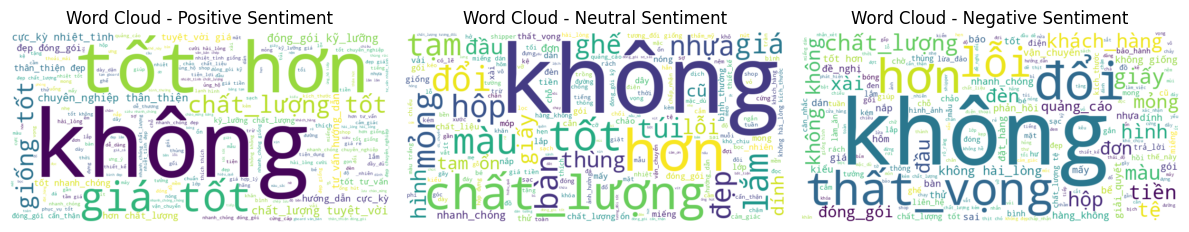

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tạo Word Cloud cho nhóm "positive"
positive_words = data[data['sentiment'] == 'positive']['new_content'].str.cat(sep=' ')
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Tạo Word Cloud cho nhóm "neutral"
neutral_words = data[data['sentiment'] == 'neutral']['new_content'].str.cat(sep=' ')
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_words)

# Tạo Word Cloud cho nhóm "negative"
negative_words = data[data['sentiment'] == 'negative']['new_content'].str.cat(sep=' ')
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Hiển thị các Word Cloud
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment')
plt.axis('off')

plt.subplot(132)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud - Neutral Sentiment')
plt.axis('off')

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment')
plt.axis('off')

plt.tight_layout()
plt.show()

In [74]:
data

,content,rating,sentiment,new_content,neutral_words_count,negative_words_count,positive_words_count,negation_words_count,positive_emoji_count,negative_emoji_count
1,Shop phục vụ khá tốt.,4,positive,phục_vụ tốt,0,0,1,0,0,0
2,Sản phẩm gần giống mô tả,3,neutral,gần giống,0,0,0,0,0,0
5,Giao hàng nhanh bất ngờ.,5,positive,nhanh_chóng,0,0,0,0,0,0
6,Sản phẩm/dịch vụ giống mô tả.,4,positive,giống,0,0,0,0,0,0
7,Sản phẩm/dịch vụ giống mô tả và tốt hơn mong đ...,5,positive,giống tốt hơn chất_lượng tốt tư_vấn hướng_d...,0,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...
16695,"Hang đong goi ok , sản phẩm chưa sủ dụng , cho...",4,positive,đong sủ_dụng,0,1,0,0,0,0
16696,"Giao hàng nhanh hơn dự kiến, đúng mẫu. Pin ok ...",5,positive,nhanh_chóng hơn dự_kiến mẫu chất_lượng,0,0,2,0,0,0
16697,Tikinow giao quá nhanh 😊😊😊,5,positive,tikinow nhanh_chóng cười cười_cười,0,0,0,0,0,0
16698,"Giao hàng nhanh, pin chính hãng nguyên đai ngu...",5,positive,nhanh_chóng hãng nguyên_đai nguyên_kiện,0,0,0,0,0,0


## Bước 4&5: Modeling & Evaluation/Analyze

In [75]:
from sklearn.metrics import roc_curve, auc, r2_score
from sklearn.preprocessing import label_binarize
from scipy.stats import pearsonr
from sklearn.naive_bayes import MultinomialNB

In [76]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['new_content'], data['sentiment'], test_size=0.2, random_state=42)

In [77]:
# Convert text data into numerical format using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [78]:
# Train a sentiment analysis model using Logistic Regression
# List of models to train and evaluate
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier(class_weight='balanced', criterion = 'entropy', max_depth = None,
                                             min_samples_leaf=1, min_samples_split= 2, splitter= 'random')),
    ("Random Forest", RandomForestClassifier(class_weight='balanced',criterion='entropy', max_depth= None,
                                             min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10)),
    ("LinearSVC", LinearSVC()),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=3)),
    ("Multinomial Naive Bayes", MultinomialNB())
]

In [79]:
import numpy as np

def ccc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)

    correlation = np.corrcoef(y_true, y_pred)[0, 1]

    true_var = np.var(y_true)
    pred_var = np.var(y_pred)

    ccc = 2 * correlation * np.sqrt(true_var * pred_var) / (true_var + pred_var + (mean_true - mean_pred) ** 2)

    return ccc

In [80]:
# Store results for each model
results = []

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

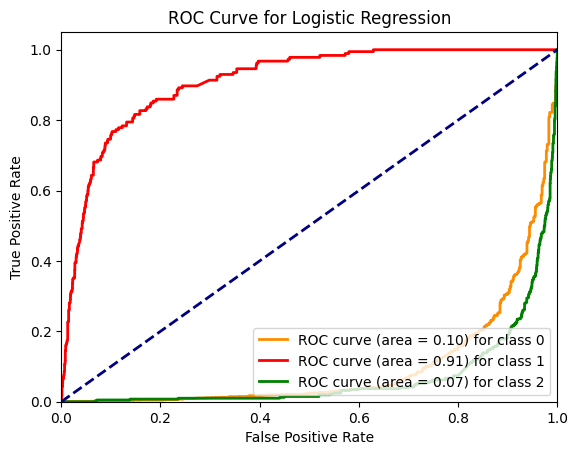

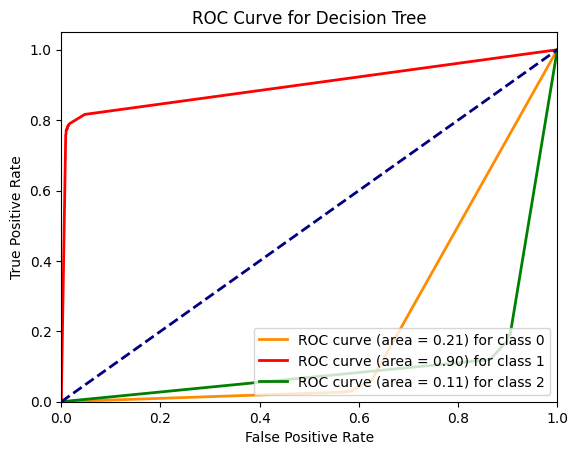

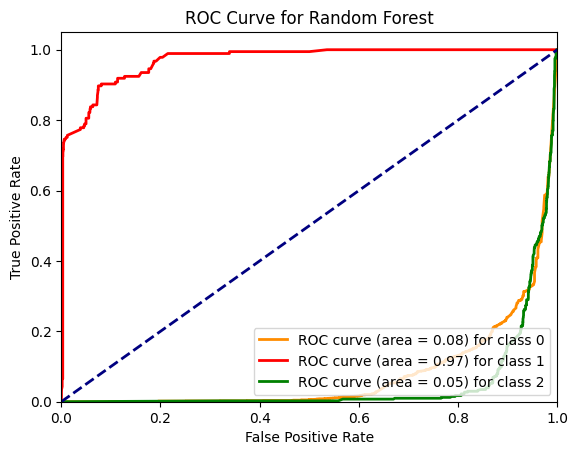

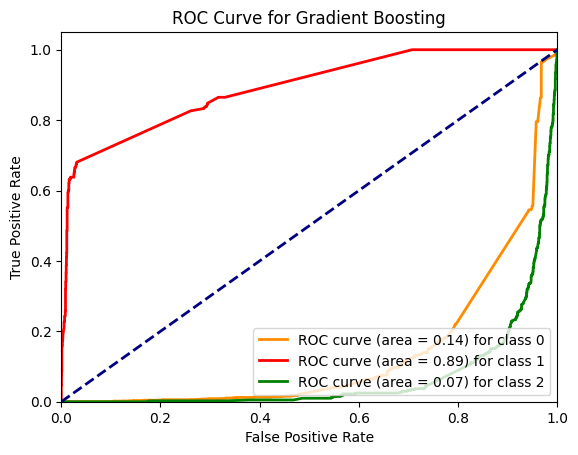

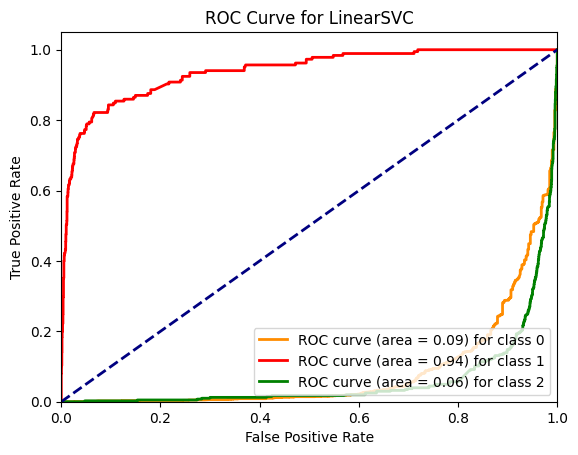

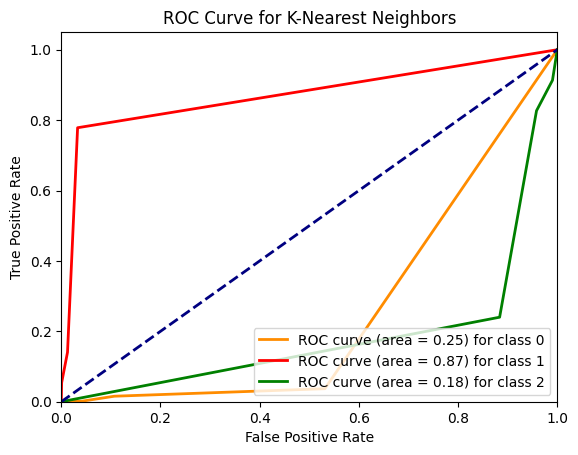

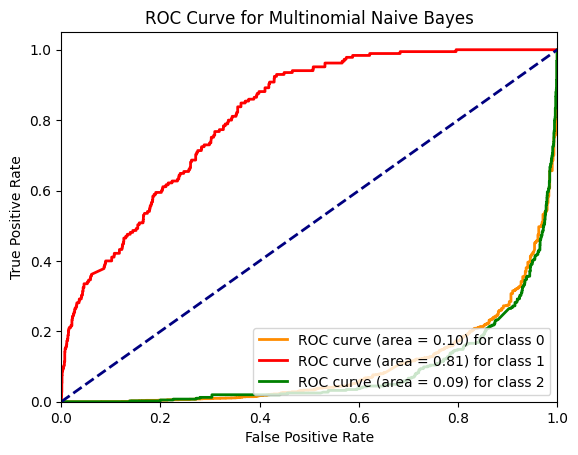

In [81]:
# Train and evaluate each classifier
for name, classifier in classifiers:
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Calculate recall and precision for each class
    recall = recall_score(y_test, y_pred, average=None, labels=['positive', 'neutral', 'negative'])
    precision = precision_score(y_test, y_pred, average=None, labels=['positive', 'neutral', 'negative'])

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])

    # Calculate R-squared for positive class
    y_test_positive_numeric = (y_test == 'positive').astype(int)
    y_pred_positive_numeric = (y_pred == 'positive').astype(int)
    r2_positive = r2_score(y_test_positive_numeric, y_pred_positive_numeric)

    # Calculate CCC for positive class
    ccc_positive = ccc(y_test_positive_numeric, y_pred_positive_numeric)

    # Calculate ROC curve and AUC for each class
    if hasattr(classifier, "decision_function"):
        y_scores = classifier.decision_function(X_test_vec)
    else:
        y_scores = classifier.predict_proba(X_test_vec)

    # Convert sentiment labels to numerical format for ROC calculation
    y_test_bin = label_binarize(y_test, classes=['positive', 'neutral', 'negative'])

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['darkorange', 'red', 'green']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc='lower right')
    plt.show()

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Positive Recall": recall[0],
        "Neutral Recall": recall[1],
        "Negative Recall": recall[2],
        "Positive Precision": precision[0],
        "Neutral Precision": precision[1],
        "Negative Precision": precision[2],
        "Confusion Matrix": cm,
        "ROC AUC (Positive)": roc_auc[0],
        "ROC AUC (Neutral)": roc_auc[1],
        "ROC AUC (Negative)": roc_auc[2],
        "R-squared (Positive)": r2_positive,
        "CCC (Positive)": ccc_positive
    })

In [82]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

results_df

,Model,Accuracy,F1 Score,Positive Recall,Neutral Recall,Negative Recall,Positive Precision,Neutral Precision,Negative Precision,Confusion Matrix,ROC AUC (Positive),ROC AUC (Neutral),ROC AUC (Negative),R-squared (Positive),CCC (Positive)
0,Logistic Regression,0.869550,0.842605,0.976967,0.054054,0.631188,0.884691,0.555556,0.770393,"[[2248, 6, 47], [146, 10, 29], [147, 2, 255]]",0.099120,0.909513,0.069370,0.262194,0.565186
1,Decision Tree,0.925606,0.925755,0.956106,0.783784,0.816832,0.958606,0.788043,0.802920,"[[2200, 33, 68], [27, 145, 13], [68, 6, 330]]",0.208781,0.899153,0.114440,0.582052,0.791815
2,Random Forest,0.942215,0.940702,0.980878,0.745946,0.811881,0.954334,0.884615,0.888889,"[[2257, 15, 29], [35, 138, 12], [73, 3, 328]]",0.078057,0.970133,0.050326,0.675877,0.831112
3,Gradient Boosting,0.897578,0.883646,0.983485,0.264865,0.698020,0.910664,0.890909,0.805714,"[[2263, 6, 32], [100, 49, 36], [122, 0, 282]]",0.136179,0.891200,0.068404,0.445580,0.686338
4,LinearSVC,0.921453,0.916891,0.977836,0.513514,0.787129,0.939457,0.840708,0.832461,"[[2250, 13, 38], [64, 95, 26], [81, 5, 318]]",0.085102,0.938141,0.061048,0.582052,0.777836
5,K-Nearest Neighbors,0.804152,0.756753,0.971751,0.140541,0.153465,0.823270,0.433333,0.543860,"[[2236, 26, 39], [146, 26, 13], [334, 8, 62]]",0.254698,0.870446,0.183023,-0.162151,0.212514
6,Multinomial Naive Bayes,0.829758,0.777298,0.995654,0.016216,0.257426,0.826479,0.750000,0.912281,"[[2291, 1, 9], [181, 3, 1], [300, 0, 104]]",0.098724,0.814775,0.087075,-0.047002,0.254821


Lựa chọn tốt nhất cho tổng thể (Overall Performance): Mô hình "Random Forest" tốt nhất với độ chính xác và F1 Score cao nhất, đặc biệt là khả năng dự đoán lớp "Neutral" và "Negative" rất tốt.

"LinearSVC" cũng là một mô hình tốt, đặc biệt trong việc dự đoán lớp "Neutral".

Lựa chọn cân bằng (Balanced Performance): "Decision Tree"có hiệu suất cân bằng, với ROC AUC khá cao cho cả ba lớp, đặc biệt là lớp "Neutral".

Lựa chọn khả năng dự đoán "Neutral" và "Negative": "K-Nearest Neighbors" và "Multinomial Naive Bayes" đều cho thấy khả năng dự đoán chưa tốt cho các lớp "Neutral" và "Negative"

### Thử thêm các cột positive_words_count,	neutral_words_count, negative_words_count,	positive_emoji_count,	negative_emoji_count xem thử mô hình có hiệu quả hơn không

In [83]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, data['sentiment'], test_size=0.2, random_state=42)

In [84]:
# Define the list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier(class_weight='balanced', criterion = 'entropy', max_depth = None,
                                             min_samples_leaf=1, min_samples_split= 2, splitter= 'random')),
    ("Random Forest", RandomForestClassifier(class_weight='balanced',criterion='entropy', max_depth= None,
                                             min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10)),
    ("LinearSVC", LinearSVC()),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=3)),
    ("Multinomial Naive Bayes", MultinomialNB())
]

In [85]:
# Store results for each model
results = []

In [86]:
from scipy.sparse import hstack

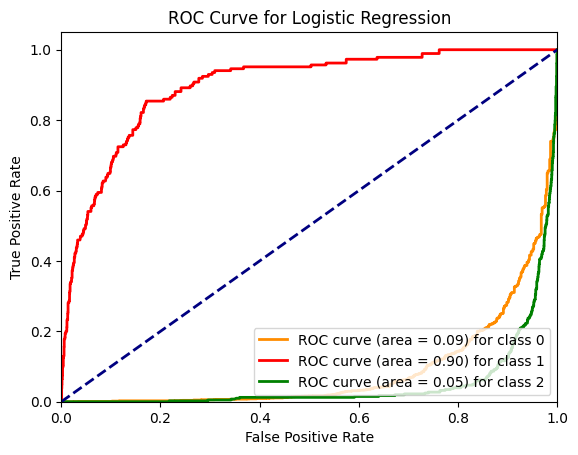

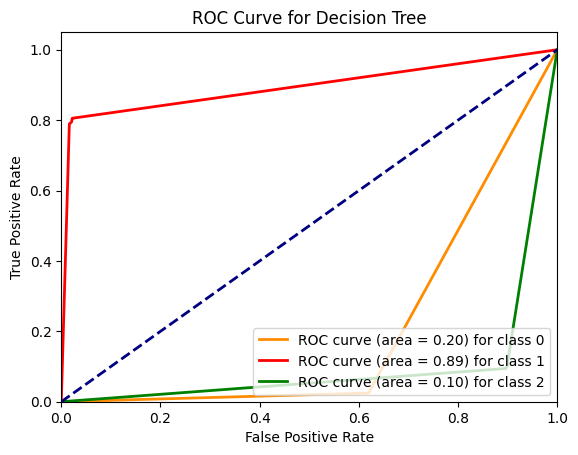

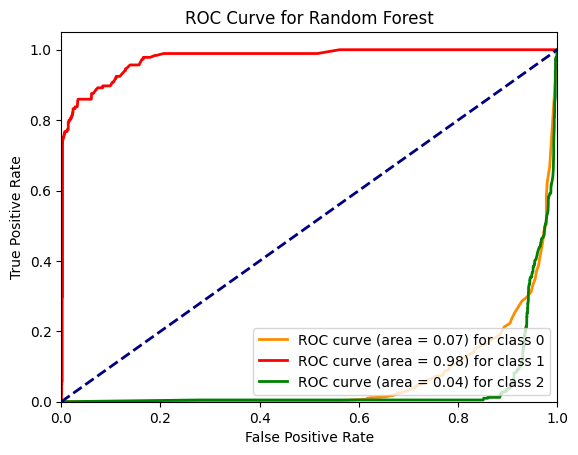

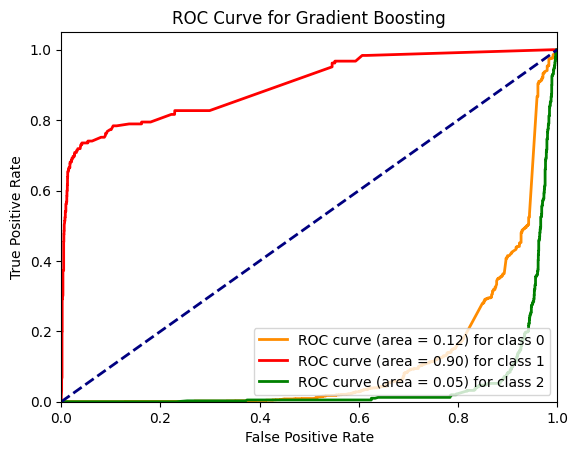

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


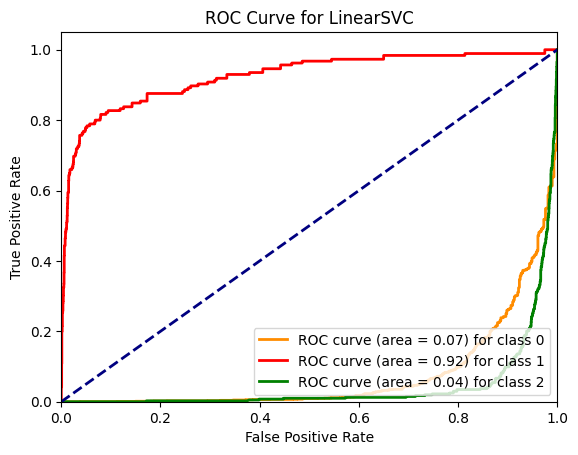

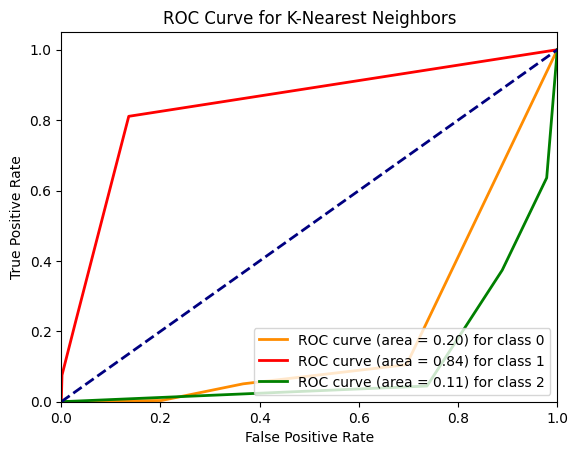

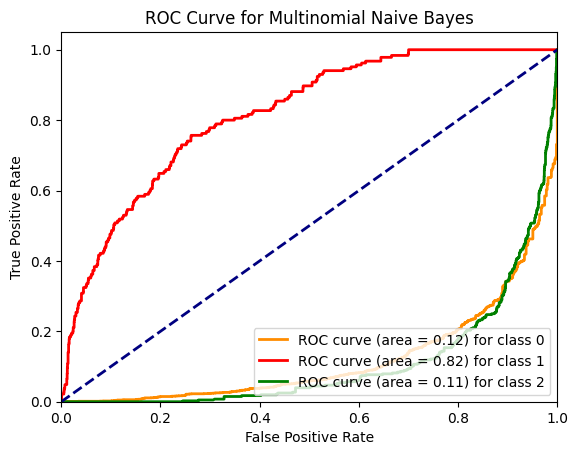

array([2.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99999999e-01,
       9.99999999e-01, 9.99999998e-01, 9.99999997e-01, 9.99999997e-01,
       9.99999996e-01, 9.99999996e-01, 9.99999995e-01, 9.99999994e-01,
       9.99999993e-01, 9.99999993e-01, 9.99999993e-01, 9.99999992e-01,
       9.99999992e-01, 9.99999992e-01, 9.99999992e-01, 9.99999992e-01,
       9.99999990e-01, 9.99999990e-01, 9.99999990e-01, 9.99999989e-01,
       9.99999989e-01, 9.99999989e-01, 9.99999975e-01, 9.99999975e-01,
       9.99999972e-01, 9.99999972e-01, 9.99999971e-01, 9.99999966e-01,
       9.99999965e-01, 9.99999960e-01, 9.99999957e-01, 9.99999884e-01,
       9.99999879e-01, 9.99999834e-01, 9.99999821e-01, 9.99999817e-01,
      

In [87]:
# Train and evaluate each classifier
for name, classifier in classifiers:
    # Combine the additional features and the preprocessed text content
    features = ["positive_words_count", "neutral_words_count", "negative_words_count", "positive_emoji_count", "negative_emoji_count"]
    X_train_text = X_train["content"]  # Training text content
    X_test_text = X_test["content"]    # Testing text content

    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_vec_text = vectorizer.fit_transform(X_train_text)
    X_test_vec_text = vectorizer.transform(X_test_text)

    # Combine text features with additional features
    X_train_combined = hstack((X_train_vec_text, X_train[features].values))
    X_test_combined = hstack((X_test_vec_text, X_test[features].values))

    # Initialize and train the classifier
    classifier.fit(X_train_combined, y_train)

    # Make predictions on the test data
    y_pred = classifier.predict(X_test_combined)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average=None, labels=['positive', 'neutral', 'negative'])
    recall = recall_score(y_test, y_pred, average=None, labels=['positive', 'neutral', 'negative'])

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])

    # Calculate R-squared for positive class
    y_test_positive = (y_test == 'positive')
    y_pred_positive = (y_pred == 'positive')

    # Calculate CCC for positive class
    ccc_positive = ccc(y_test_positive, y_pred_positive)

    # Calculate R-squared for positive class
    y_test_positive_numeric = (y_test == 'positive').astype(int)
    y_pred_positive_numeric = (y_pred == 'positive').astype(int)
    r2_positive = r2_score(y_test_positive_numeric, y_pred_positive_numeric)

    # Calculate ROC curve and AUC for each class
    if hasattr(classifier, "decision_function"):
        y_scores = classifier.decision_function(X_test_combined)
    else:
        y_scores = classifier.predict_proba(X_test_combined)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        y_test_bin = label_binarize(y_test, classes=['positive', 'neutral', 'negative'])
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['darkorange', 'red', 'green']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc='lower right')
    plt.show()

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Positive Recall": recall[0],
        "Neutral Recall": recall[1],
        "Negative Recall": recall[2],
        "Positive Precision": precision[0],
        "Neutral Precision": precision[1],
        "Negative Precision": precision[2],
        "Confusion Matrix": cm,
        "ROC AUC (Positive)": roc_auc[0],
        "ROC AUC (Neutral)": roc_auc[1],
        "ROC AUC (Negative)": roc_auc[2],
        "R-squared (Positive)": r2_positive,
        "CCC (Positive)": ccc_positive
    })
_

In [88]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,F1 Score,Positive Recall,Neutral Recall,Negative Recall,Positive Precision,Neutral Precision,Negative Precision,Confusion Matrix,ROC AUC (Positive),ROC AUC (Neutral),ROC AUC (Negative),R-squared (Positive),CCC (Positive)
0,Logistic Regression,0.890657,0.870779,0.979140,0.135135,0.732673,0.904819,0.781250,0.804348,"[[2253, 6, 42], [130, 25, 30], [107, 1, 296]]",0.087913,0.896788,0.050772,0.392270,0.654945
1,Decision Tree,0.933564,0.934795,0.953933,0.805405,0.876238,0.972099,0.709524,0.838863,"[[2195, 49, 57], [25, 149, 11], [38, 12, 354]]",0.202466,0.893758,0.098317,0.639627,0.824578
2,Random Forest,0.951211,0.949207,0.993481,0.745946,0.804455,0.949730,0.932432,0.970149,"[[2286, 9, 6], [43, 138, 4], [78, 1, 325]]",0.067088,0.975282,0.039393,0.709995,0.844593
3,Gradient Boosting,0.948443,0.945582,0.990439,0.616216,0.861386,0.953956,0.966102,0.908616,"[[2279, 4, 18], [54, 114, 17], [56, 0, 348]]",0.116563,0.898396,0.048479,0.718525,0.850980
4,LinearSVC,0.922837,0.917736,0.977836,0.475676,0.814356,0.940635,0.822430,0.841432,"[[2250, 11, 40], [75, 88, 22], [67, 8, 329]]",0.073583,0.924368,0.043231,0.588449,0.781676
5,K-Nearest Neighbors,0.824221,0.817433,0.916993,0.227027,0.569307,0.893689,0.350000,0.562347,"[[2110, 55, 136], [100, 42, 43], [151, 23, 230]]",0.198452,0.842059,0.110880,0.057485,0.510180
6,Multinomial Naive Bayes,0.829758,0.808836,0.923946,0.021622,0.663366,0.894781,0.500000,0.529644,"[[2126, 4, 171], [114, 4, 67], [136, 0, 268]]",0.120464,0.815857,0.109695,0.093736,0.524336


Sau khi đưa thêm một số thông số vào thì có cải thiện đáng kể trong kết quả, đặc biệt là 2 mô hình decision tree và random forest

Accuracy: Tổng thể, tất cả các mô hình mới có độ chính xác cao hơn so với dữ liệu trước đó. Điều này có nghĩa các mô hình đã cải thiện khả năng phân loại tổng quan. Trong đó Gradient Boosting	có chỉ số tốt nhất

F1 Score: F1 Score là một độ đo tổng hợp của precision và recall. Các mô hình mới cũng có F1 Score cao hơn, cho thấy sự cải thiện trong việc cân bằng giữa precision và recall.

Positive Recall: Các mô hình mới có khả năng dự đoán sentiment là "positive" tốt hơn so với dữ liệu trước đó. Điều này cho thấy khả năng cải thiện trong việc phát hiện các trường hợp tích cực.

Neutral Recall: Mô hình "Decision Tree" có hiệu suất tốt nhất trong việc dự đoán sentiment là "neutral," so với dữ liệu trước đó.

Negative Recall: Mô hình "LinearSVC" cũng có hiệu suất tốt hơn trong việc dự đoán sentiment là "negative" so với dữ liệu trước đó.

Với các nhóm chỉ số Precision thì mô hình Gradient Boosting và Random Forest cho kết quả tốt hơn các mô hình khác ở phân lớp Neutral và Negative, điều này cho thấy mô hình này ít đưa ra các dự đoán nhầm lẫn cho các phân lớp này, tuy nhiên việc phát hiện ra các đánh giá Neutral và Negative của mô hình này lại không tốt bằng các mô hình khác

ROC AUC: Giá trị ROC AUC của các mô hình mới được cải thiện so với dữ liệu trước đó. Điều này cho thấy khả năng cải thiện trong khả năng phân loại.

Tổng cộng, dựa trên các chỉ số đánh giá, các mô hình mới có khả năng dự đoán sentiment tốt hơn so với dữ liệu trước đó, đặc biệt là trong việc phân loại "neutral" và "negative."

## Bước 6: Deployment and Feedback/Act

### Tùy thuộc vào mục tiêu có thể có những cân nhắc sau:
---
Lựa chọn tốt nhất cho tổng thể (Overall Performance): dựa vào độ chính xác (Accuracy) và F1 Score, ta có thể nhận thấy mô hình "Random Forest" và "Gradient Boosting" đều mang lại hiệu suất cao. Cả hai mô hình đều có độ chính xác và F1 Score cao, cũng như hiệu suất dự đoán tốt đối với các loại sentiment "positive," "neutral," và "negative."
Dựa vào nhận xét đã cho, mô hình "Decision Tree" có thể là lựa chọn tốt nhất vì nó mang lại hiệu suất cân bằng trên tất cả các loại sentiment và có ROC AUC cao cho cả ba loại.
Lựa chọn khả năng dự đoán "Neutral" và "Negative": mô hình "Decision Tree" cũng là lựa chọn tốt nhất khi ưu tiên khả năng dự đoán các trường hợp "neutral" và "negative" vì nó cho hiệu suất tốt nhất đối với cả hai loại sentiment này, với Neutral Recall và Negative Recall.

Nhóm quyết định lựa chọn mô hình Random Forest vì nó có độ cân bằng tốt hơn và có thể dự đoán được chính xác cả 3 nhóm Positive, Neutral và Negative

In [89]:
'''
from sklearn.model_selection import GridSearchCV

# Combine the additional features and the preprocessed text content
features = ["positive_words_count", "neutral_words_count", "negative_words_count", "positive_emoji_count", "negative_emoji_count"]
X_train_text = X_train["content"]  # Training text content
X_test_text = X_test["content"]    # Testing text content

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec_text = vectorizer.fit_transform(X_train_text)
X_test_vec_text = vectorizer.transform(X_test_text)

# Combine text features with additional features
X_train_combined = hstack((X_train_vec_text, X_train[features].values))
X_test_combined = hstack((X_test_vec_text, X_test[features].values))

# Xác định các giá trị của các siêu tham số bạn muốn thử
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Tạo mô hình Decision Tree
decision_tree = DecisionTreeClassifier()

# Sử dụng Grid Search để tìm các giá trị tốt nhất cho các siêu tham số
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec_text, y_train)  # X_train và y_train là dữ liệu huấn luyện của bạn

# In ra các siêu tham số tốt nhất và độ chính xác tương ứng
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Combine the additional features and the preprocessed text content\nfeatures = ["positive_words_count", "neutral_words_count", "negative_words_count", "positive_emoji_count", "negative_emoji_count"]\nX_train_text = X_train["content"]  # Training text content\nX_test_text = X_test["content"]    # Testing text content\n\n# Vectorize the text data using TF-IDF\nvectorizer = TfidfVectorizer()\nX_train_vec_text = vectorizer.fit_transform(X_train_text)\nX_test_vec_text = vectorizer.transform(X_test_text)\n\n# Combine text features with additional features\nX_train_combined = hstack((X_train_vec_text, X_train[features].values))\nX_test_combined = hstack((X_test_vec_text, X_test[features].values))\n\n# Xác định các giá trị của các siêu tham số bạn muốn thử\nparam_grid = {\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'splitter\': [\'best\', \'random\'],\n    \'max_depth\': [None, 10, 20, 30, 40, 50],\n    \'min_samples_split\': [2, 5

In [90]:
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Định nghĩa các giá trị của các siêu tham số bạn muốn thử
param_grid = {
    'n_estimators': [50, 100, 200],  # Số cây quyết định
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5],  # Số lượng mẫu tối thiểu để chia một nút
    'min_samples_leaf': [1, 2]    # Số lượng mẫu tối thiểu trên mỗi lá
}

# Tạo mô hình Random Forest
random_forest = RandomForestClassifier()

# Sử dụng Grid Search để tìm các giá trị tốt nhất cho các siêu tham số
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_combined, y_train)  # X_train_combined và y_train là dữ liệu huấn luyện của bạn

# In ra các siêu tham số tốt nhất và độ chính xác tương ứng
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV\n\n# Định nghĩa các giá trị của các siêu tham số bạn muốn thử\nparam_grid = {\n    \'n_estimators\': [50, 100, 200],  # Số cây quyết định\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'max_depth\': [None, 10, 20, 30],  # Độ sâu tối đa của cây\n    \'min_samples_split\': [2, 5],  # Số lượng mẫu tối thiểu để chia một nút\n    \'min_samples_leaf\': [1, 2]    # Số lượng mẫu tối thiểu trên mỗi lá\n}\n\n# Tạo mô hình Random Forest\nrandom_forest = RandomForestClassifier()\n\n# Sử dụng Grid Search để tìm các giá trị tốt nhất cho các siêu tham số\ngrid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring=\'accuracy\')\ngrid_search.fit(X_train_combined, y_train)  # X_train_combined và y_train là dữ liệu huấn luyện của bạn\n\n# In ra các siêu tham số tốt nhất và độ chính xác tương ứng\nprint("Best Parameters: ", grid_search.best_params_)\nprint("Best Accuracy: ", grid_search.be

In [91]:
import joblib
from sklearn.ensemble import RandomForestClassifier

# Tạo mô hình Random Forest
random_forest = RandomForestClassifier(class_weight='balanced',criterion='entropy', max_depth= None,
                                       min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)

# Huấn luyện mô hình
random_forest.fit(X_train_combined, y_train)

# Lưu mô hình vào một tệp
joblib.dump(random_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [92]:
joblib.dump(random_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [93]:
# Định nghĩa hàm tiền xử lý
def preprocess_input(input_text, emoji_dict, teen_dict, wrong_lst, neutral_words, negative_words, positive_words, negation_words, positive_emojis, negative_emojis, stopwords_lst):
    # Bước 1: Áp dụng hàm xử lý văn bản
    processed_text = process_text(input_text, emoji_dict, teen_dict, wrong_lst)

    # Bước 2: Chuyển đổi ký tự unicode
    processed_text = covert_unicode(processed_text)

    # Bước 3: Tính toán số lượng từ và emoji mang tính cảm xúc
    neutral_word_count = find_words_test(processed_text, neutral_words)[0]
    negative_word_count = find_words_test(processed_text, negative_words)[0]
    positive_word_count = max(find_words_test(processed_text, positive_words)[0] - find_words_test(processed_text, negation_words)[0],0)
    positive_emoji_count = find_words_test(processed_text, positive_emojis)[0]
    negative_emoji_count = find_words_test(processed_text, negative_emojis)[0]

    # Bước 4: Tách từ và loại bỏ stopwords
    tokenized_text = word_tokenize(processed_text, format="text")
    tokenized_text = remove_stopword(tokenized_text, stopwords_lst)

    # Bước 5: Áp dụng POS tagging
    tokenized_text = ViTokenizer.tokenize(tokenized_text)
    tokenized_text = re.sub(r'\.', '', tokenized_text)

    # Gom các thông tin đã xử lý vào một dictionary
    processed_data ={
        "processed_text": tokenized_text,
        "neutral_word_count": neutral_word_count,
        "negative_word_count": negative_word_count,
        "positive_word_count": positive_word_count,
        "positive_emoji_count": positive_emoji_count,
        "negative_emoji_count": negative_emoji_count
    }

    return processed_data

In [94]:
# Lưu vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [95]:
import joblib
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the trained model and vectorizer
vectorizer = joblib.load('tfidf_vectorizer.pkl')
model = joblib.load('random_forest_model.pkl')

In [96]:
def predict_sentiment(user_input):
    # Bước 1: Tiền xử lý đầu vào từ người dùng
    processed_data = preprocess_input(user_input, emoji_dict, teen_dict, wrong_lst, neutral_words, negative_words, positive_words, negation_words, positive_emojis, negative_emojis, stopwords_lst)

    # Bước 2: Trích xuất các đặc trưng
    processed_text = processed_data['processed_text']
    feature_values = [
        processed_data['neutral_word_count'],
        processed_data['negative_word_count'],
        processed_data['positive_word_count'],
        processed_data['positive_emoji_count'],
        processed_data['negative_emoji_count']
    ]

    # Bước 3: Vector hóa văn bản đã được tiền xử lý
    text_vectorized = vectorizer.transform([processed_text])

    # Bước 4: Kết hợp đặc trưng văn bản với các đặc trưng bổ sung
    features_combined = hstack((text_vectorized, np.array(feature_values).reshape(1, -1)))

    # Bước 5: Viết hàm dự báo
    prediction = model.predict(features_combined)

    return prediction[0]

In [97]:
def find_words_test(document, list_of_words):
    document_lower = document.lower()
    word_count = 0
    word_list = []

    for word in document_lower.split():  # Tách văn bản thành từng chữ
        if word in list_of_words:
            word_count += 1  # Tăng biến đếm mỗi khi tìm thấy một chữ trong list_of_words
            word_list.append(word)

    return word_count, word_list